**Задание 3: Эксперименты и анализ (20 баллов)**\
**3.1 Исследование гиперпараметров (10 баллов)**

**Класс LinearRegression и CustomCSVDataset с прошлой части**

In [3]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

class LinearRegression(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.linear(x).squeeze(1)
    
class CustomCSVDataset(Dataset):
    def __init__(self, filepath, target_col):
        self.data = pd.read_csv(filepath) #Загружаем CSV-файл

        self.data = self.data.dropna() #удаление строк с пропусками

        self.X = self.data.drop(columns=[target_col]) #Отделяем признаки
        self.y = self.data[target_col] #целевая

        cat_cols = self.X.select_dtypes(include='object').columns #Находим категориальные признаки

        #Кодируем категориальные признаки
        for col in cat_cols:
            self.X[col] = LabelEncoder().fit_transform(self.X[col])

        num_cols = self.X.drop(columns=cat_cols).select_dtypes(include='number').columns #Находим числовые признаки (исключая категориальные)

        #Нормализуем числовые признаки
        scaler = StandardScaler()
        self.X[num_cols] = scaler.fit_transform(self.X[num_cols])

        # Если задача регрессии — нормализуем и y
        if self.y.nunique() > 2:
            self.y_scaler = StandardScaler()
            self.y = self.y_scaler.fit_transform(self.y.values.reshape(-1, 1)).flatten()
            self.is_regression = True
        else:
            self.y = LabelEncoder().fit_transform(self.y)
            self.is_regression = False

        self.X = torch.tensor(self.X.values, dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32 if self.is_regression else torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


**Обучение с разными параметрами**

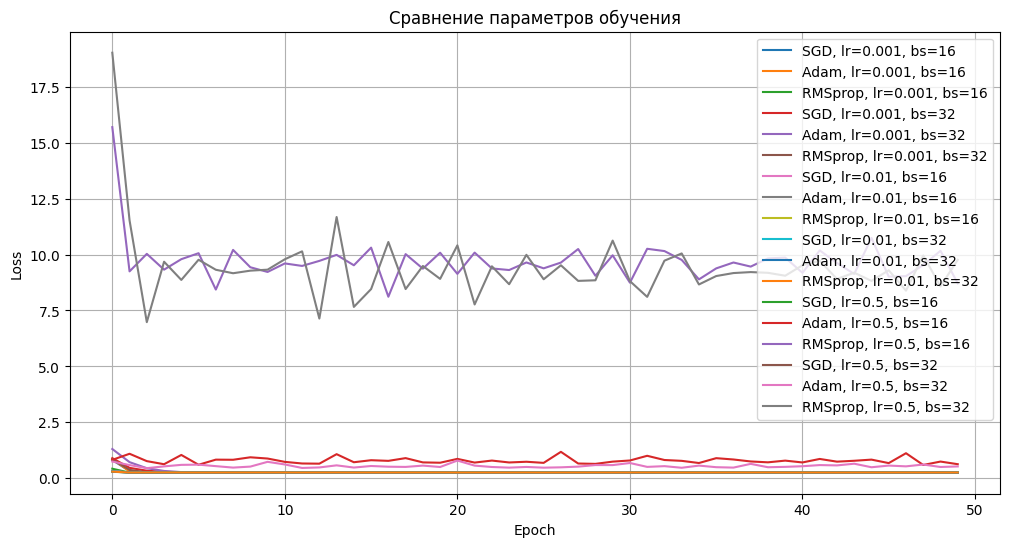

In [10]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim

dataset = CustomCSVDataset(filepath="used_car_price_dataset_extended.csv", target_col="price_usd")

#Подбираем разные параметры
lrs = [0.001, 0.01, 0.5]
batch_sizes = [16, 32]
opt = ['SGD', 'Adam', 'RMSprop']

results = {}
#перебираем все размера батча, скорорости обучения и оптимизаторы
for lr in lrs:
    for batch_size in batch_sizes:
        for opt_name in opt:
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            model = LinearRegression(in_features=dataset.X.shape[1])
            criterion = nn.MSELoss()

            if opt_name == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr)
            elif opt_name == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif opt_name == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=lr)

            # Обучение
            losses = [] #сохраняем лоссы
            for epoch in range(1, 51):
                total_loss = 0
                for batch_X, batch_y in dataloader:
                    optimizer.zero_grad()
                    y_pred = model(batch_X)
                    loss = criterion(y_pred, batch_y)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()

                avg_loss = total_loss / len(dataloader)
                losses.append(avg_loss)

            label = f"{opt_name}, lr={lr}, bs={batch_size}"
            results[label] = losses

#Визуализация
plt.figure(figsize=(12, 6))
for label, loss_history in results.items():
    plt.plot(loss_history, label=label)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Сравнение параметров обучения")
plt.legend()
plt.grid(True)
plt.savefig(r"C:\Users\mrtar\OneDrive\Рабочий стол\prakt\HW2\plots\comparison_plot.png", dpi=300)
plt.show()

**3.2 Feature Engineering (10 баллов)**

In [9]:
from utils import log_epoch
df = pd.read_csv("used_car_price_dataset_extended.csv")

#Добавляем полиномиальный признак
if "year" in df.columns:
    df["year_squared"] = df["year"] ** 2

#Добавляем взаимодействие признаков
if {"mileage", "engine_size"}.issubset(df.columns):
    df["mileage_plus_engine"] = df["mileage"] + df["engine_size"]

#Добавляем статистические признаки
numeric_cols = df.select_dtypes(include=np.number).columns.drop("price_usd", errors='ignore')
df["mean_feature"] = df[numeric_cols].mean(axis=1)
df["std_feature"] = df[numeric_cols].std(axis=1)

#Сохраняем новый CSV
df.to_csv("car_data_extended.csv", index=False)


dataset = CustomCSVDataset(filepath="car_data_extended.csv", target_col="price_usd")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = LinearRegression(in_features=dataset.X.shape[1])
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 100
for epoch in range(1, epochs + 1):
    total_loss = 0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    if epoch % 10 == 0:
        log_epoch(epoch, avg_loss)

Epoch 10: loss=0.2348
Epoch 20: loss=0.2351
Epoch 30: loss=0.2361
Epoch 40: loss=0.2343
Epoch 50: loss=0.2340
Epoch 60: loss=0.2344
Epoch 70: loss=0.2347
Epoch 80: loss=0.2328
Epoch 90: loss=0.2358
Epoch 100: loss=0.2339
